In [3]:
#This is a copy of gsw.py at the time of writing except with some modifications in next_direction

import numpy as np
from itertools import compress
import random
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (16, 20)
from mpl_toolkits.mplot3d import Axes3D 
import tikzplotlib
from itertools import chain, combinations
import pickle
import sys
import sklearn.linear_model as sklm
import quadprog
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
float_formatter = "{:.3e}".format
#np.set_printoptions(formatter={'float_kind':float_formatter})
#plt.rcParams.update({'font.size': 22})

def get_alives(x,a,b,basis,previous=None,thresh=1e-12,debug=False):
    if debug:
        print(f'Computing the list of elements that are alive with threshold {thresh}')
        print(f'x: {x}')
        print(f'a: {a}')
        print(f'b: {b}')
    x_=change_basis(x.copy(),orthonormal_basis(len(x)),basis)
    #print('get_alives')
    #print(x_)
    if sum((x_-a)>-thresh)<len(x_) or sum((b-x_)>-thresh)<len(x_):
        print('Issue: x is out of bound!')
        debug=True
    alive=(np.abs(x_-a)>thresh) & (np.abs(x_-b)>thresh)
    #print(alive)
    return alive,debug,None if previous is None else [i for i in range(len(alive)) if ((previous[i]) and not alive[i])]

def choose_pivot(v,x,alive,mode='max_norm',debug=False):
    if debug:
        print(f'Choosing pivot through mode {mode}.')
        print(f'x: {x}')
        print(f'Alive: {alive}')
    if mode=='max_index':
        for i in range(len(x),0,-1):
            if alive[i]:
                return i
        return -1
    elif mode=='random':
        try:
            return random.choice(np.arange(len(x))[alive])
        except IndexError:
            #print('Every element is fixed')
            return -1
    elif mode=='max_norm':
        norms=[norm(v[i]) if alive[i] else 0 for i in range(len(v))]
        return np.argmax(norms) if max(norms)!=0 else -1
    else:
        return -1

def next_direction(p,v,x,a,b,alive,old_alive_and_not_pivot,basis,X_t=None,debug=False,bigger_first=False,force_balance=False,fast_lst_sq=True,d_instead_of_d_inv=True,i_instead_of_d_inv=True):
    u=np.zeros(len(v))
    u[p]=1
    B=np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis])).T)#is v already a list ? If so we can simplify syntax here
    alive_and_not_pivot=alive.copy()
    alive_and_not_pivot[p]=False
    if debug:
        print(f'Alive and not pivot: {alive_and_not_pivot}')
    alive_and_not_pivot=np.asarray(alive_and_not_pivot)
    B_t=B[:,alive_and_not_pivot]
    if alive_and_not_pivot.any():
        q,r=np.linalg.qr(B[:,alive_and_not_pivot])
        rs=np.array([(r[i,:]==np.zeros(r.shape[1])).all() for i in range(r.shape[0])])
        if len(rs)!=0:
            q=q[:,~rs]
            v_perp=B[:,p]-q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T).dot(B[:,p])
        else:
            v_perp=B[:,p]
    else:
        v_perp=B[:,p]
    if ((v_perp)<1e-12).all() and bigger_first:
        model=sklm.Lasso(fit_intercept=False,alpha=1e-32)
        model.fit(B_t,-B[:,p])
        u1=model.coef_
        colinear=True
        u[alive_and_not_pivot]=u1
    elif not force_balance:
        if fast_lst_sq and B_t.shape[0]>=B_t.shape[1]:
            if X_t is None:
                X_t=inv(B_t.T.dot(B_t))
            else:
                indices_to_update=[sum(alive_and_not_pivot[:x]) for x in range(alive_and_not_pivot.shape[0]) if ((not alive_and_not_pivot[x]) and old_alive_and_not_pivot[x])]
                indices_to_update.reverse()
                if debug:
                    print(f'indices to update: {indices_to_update}')
                for k in indices_to_update:
                    #print(X_t[:,k])
                    #print(X_t[k,:])
                    update=X_t[k,k]**-1*np.matmul(X_t[:,k].reshape((X_t.shape[0],1)),X_t[k,:].reshape((1,X_t.shape[0])))
                    if debug:
                        print(f'X_t:{X_t}')
                        print(f'update: {update}')
                    X_t=(X_t-update)
                    X_t=np.delete(X_t,k,0)
                    X_t=np.delete(X_t,k,1)
                if debug:
                    error=X_t-inv(B_t.T.dot(B_t))
                    if error.shape[0]!=0 and np.max(np.abs(error))>1e-9:
                        print(f'error:{error}')
                        print(np.max(np.abs(error)))
            u1=np.matmul(X_t.dot(B_t.T),(-B[:,p]))
            if d_instead_of_d_inv:
                d=np.diag([norm(B_t[:,i]) for i in range(B_t.shape[1])])
                u1=d.dot(d).dot(u1)
            if i_instead_of_d_inv:
                d=np.diag([norm(B_t[:,i]) for i in range(B_t.shape[1])])
                u1=d.dot(u1)
            if debug:
                u1_=np.linalg.lstsq(B_t,-B[:,p])[0]
                error=u1-u1_
                if error.shape[0]!=0 and np.max(np.abs(error))>1e-9:
                    print(f'final error:{error}')
                    print(np.max(np.abs(error)))            
        else:
            u1=np.linalg.lstsq(B_t,-B[:,p])[0]
        colinear=False
        u[alive_and_not_pivot]=u1
    else:
        P=B.T.dot(B)
        A=np.eye(len(v))[~alive_and_not_pivot,:]
        A=np.vstack((A,np.ones(len(v))))
        b=np.zeros(len(v))
        b[p]=1
        b=b[~alive_and_not_pivot]
        b=np.append(b,0)
        u=quadprog_solve_qp(P,np.zeros(len(v)),A=A,b=b)
        colinear=False
    if debug or (max(np.abs(v_perp-B.dot(u)))>1e-9 and not force_balance and not d_instead_of_d_inv and not i_instead_of_d_inv):
        print(f'v_perp:{v_perp}')
        print(f'v_perp-sum u_i*v_i:{v_perp-B.dot(u)}')
    if debug:
        print(f'Calculated update direction u:{u}')
    return change_basis(u,basis,orthonormal_basis(len(u))),colinear,X_t,alive_and_not_pivot

def quadprog_solve_qp(P, q, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    qp_C = -A.T
    qp_b = -b
    meq = A.shape[0]
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

def next_factor(x,u_,p,a,b,basis,colinear,debug=False,smallest_delta=False,bigger_first=False):
    u=change_basis(u_,orthonormal_basis(len(x)),basis)
    non_zero=np.abs(u)>1e-10
    x_=change_basis(x,orthonormal_basis(len(x)),basis)[non_zero]
    deltas=np.concatenate(((a[non_zero]-x_)/u[non_zero],(b[non_zero]-x_)/u[non_zero]),axis=0)
    if debug:
        print(f'All deltas considered:{deltas}')
    try:
        d_p=min(deltas[deltas>=0])
        if debug:
            print(f'delta_+:{d_p}')
    except:
        print(f'No delta>=0: {deltas}')#could set d_p=0 maybe
    try:
        d_m=max(deltas[deltas<=0])
        if debug:
            print(f'delta_-:{d_m}')
    except:
        print(f'No delta<=0: {deltas}')#could set d_m=0 maybe
    if not bigger_first or not colinear or x[p]==0:
        r=random.random()
        if r>d_p/(d_p-d_m) or (smallest_delta and d_p<abs(d_m)):
            if debug:
                print('delta=delta_+')
            return d_p,d_m
        else:
            if debug:
                print('delta=delta_-')
            return d_m,d_p
    else:
        if x[p]>0:
            if debug:
                print('delta=delta_+')
            return d_p,d_m
        else:
            if debug:
                print('delta=delta_-')
            return d_m,d_p

def change_basis(v,basis1,basis2):#from basis1 to basis2
    return np.matmul(np.linalg.inv(np.transpose(np.array(basis2))),np.matmul(np.transpose(np.array(basis1)),v))

def orthonormal_basis(n):
    basis=[]
    for i in range(n):
        v_i=np.zeros(n)
        v_i[i]=1
        basis.append(v_i)
    return basis

def gram_schmidt_walk(v,x,a=None,b=None,plot=False,debug=False,smallest_delta=False,basis=None,order=False,bigger_first=False,force_balance=False,fast_lst_sq=True,d_instead_of_d_inv=False,i_instead_of_d_inv=False):
    if a is None:
        if debug:
            print('Initializing a with -1s')
        a=-np.ones(len(x))
    if b is None:
        if debug:
            print('Initializing b with 1s')
        b=np.ones(len(x))
    if basis is not None and len(basis)<len(x):
        print('Basis is lacking vectors to be full-dimensional: replacing it by a canonical orthonormal basis')#could complete it with Gram-Schmidt maybe
        basis=None
    if basis is not None and np.linalg.cond(np.array(basis)) > 1/sys.float_info.epsilon:
        print('Basis matrix is singular: replacing it by a canonical orthonormal basis')
        basis=None
    if basis is None:
        basis=orthonormal_basis(len(v))
    if sum(a<b)<len(x):
        print('Issue with hyper parallelepipeds: a>b for some dimension')
    alive,debug,_=get_alives(x,a,b,basis,debug=debug)
    p=choose_pivot(v,x,alive,debug=debug,mode='random' if not bigger_first else 'max_norm')
    i=1
    colored=[]
    X_t=None
    old_alive=alive
    while p!=-1:
        if debug:
            print(f'\n Iteration {i}')
        u,colinear,X_t,old_alive=next_direction(p,v,x,a,b,alive,old_alive,basis,X_t,debug=debug,bigger_first=bigger_first,force_balance=force_balance,fast_lst_sq=fast_lst_sq,d_instead_of_d_inv=d_instead_of_d_inv,i_instead_of_d_inv=i_instead_of_d_inv)
        d1,d2=next_factor(x,u,p,a,b,basis,colinear,debug=debug,smallest_delta=smallest_delta,bigger_first=bigger_first)
        if plot:
            plot_situation_v2(v,p,x,u,[d1,d2],i)
        x+=d1*u
        if debug:
            print(f'Incurred discrepancy:{norm(np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),x))}')
        alive,debug,newly_colored=get_alives(x,a,b,basis,alive,debug=debug)
        if debug:
            print('')
        colored.extend(newly_colored)
        if not alive[p]:
            p=choose_pivot(v,x,alive,debug=debug,mode='random' if not bigger_first else 'max_norm')
        i+=1
        if i-5>len(x):
            print('Issue, the algorithm took more steps than expected')
            print(f'x:{x}')
            print(f'u:{u}')
            print(f'delta: {d1}')
            return None
        if debug:
            print('in basis')
            print(f'x:{change_basis(x,orthonormal_basis(len(x)),basis)}')
            print(f'u:{change_basis(u,orthonormal_basis(len(x)),basis)}')
    if order:
        return x,colored
    else:
        return x

def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

def sample_from_sphere(n):
    thetas=np.random.uniform(0,2*np.pi,n)
    return [np.array([np.sin(t),np.cos(t)]) for t in thetas]

def sample_from_ball(n,d=2):
    p=[]
    for i in range(n):
        u = np.random.normal(0,1,d)  # an array of d normally distributed random variables
        norm=np.sum(u**2) **(0.5)
        r = random.random()**(1.0/d)
        p.append(r*u/norm)
    return p
    #r = np.random.uniform(0,1,n)**0.5
    #theta = np.random.uniform(0,2*np.pi,n)
    #x = r*np.cos(theta)
    #y = r*np.sin(theta)
    #return [np.array([x[i],y[i]]) for i in range(n)]
    
def sample_binary(n,d,p=0.5):
    return [np.random.binomial(size=d, n=1, p=p) for i in range(n)]

def inv(m):
    a,_ = m.shape
    i = np.eye(a, a)
    sol=np.linalg.lstsq(m, i)
    #print(sol[3])
    return sol[0]

def latex_vector(x):
    return str(list(x)).replace('[','').replace(']','').replace(',','\\ \n')

def plot_situation(v,p,x,u,deltas,i):
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
    B=np.transpose(np.vstack(tuple([e for e in v])))
    plt.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current relaxation',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    plt.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'H',label='Potential updated relaxation')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.63,0.05, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    plt.legend(bbox_to_anchor=(1.8, 1))
    tikzplotlib.save(f"gswalk{i}2d.tex")
    plt.show()
    if x.shape[0]==3:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]])

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x,y = np.meshgrid(tmp,tmp)
        z = 0*x

        ax.plot_surface(z+1,x,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.savefig(f"gswalk{i}3d.png")
        plt.legend()
        tikzplotlib.save(f"gswalk{i}3d.tex")
        plt.show()
        
def plot_situation_v2(v,p,x,u,deltas,i):
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    fig.subplots_adjust(wspace=0.1, hspace=0)
    ax1 = fig.add_subplot(1, 2, 2)
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])<1],[v[e][1] for e in range(len(v)) if np.abs(x[e])<1],'o',label='Colorless vector')
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])==1],[v[e][1] for e in range(len(v)) if np.abs(x[e])==1],'o',label='Colored vector')
    ax1.plot(v[p][0],v[p][1],'*',label='Pivot vector',markersize=12)
    B=np.transpose(np.vstack(tuple([e for e in v])))
    ax1.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current balance',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    ax1.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'<',label='Potential update')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.45,0.04, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    #ax1.legend(bbox_to_anchor=(0,0),loc='lower center')

    #tikzplotlib.save(f"gswalk{i}2d.tex")
    #plt.show()
    if x.shape[0]==3:
        #fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x_,y = np.meshgrid(tmp,tmp)
        z = 0*x_

        ax.plot_surface(z+1,x_,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x_,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x_,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x_,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x_,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x_,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Potential update')
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        #ax.set_xlabel('X')
        #ax.set_ylabel('Y')
        #ax.set_zlabel('Z')
        ax.legend(bbox_to_anchor=(0.8, -0.07))
    ax1.legend(bbox_to_anchor=(1.1, -0.07),ncol=2)
    plt.savefig(f"gswalkboth{i}.pdf", bbox_inches='tight')
    tikzplotlib.save(f"gswalk{i}both.tex")
    plt.show()
    
def naive_walk(vs_):
    vs=vs_.copy()
    indices=list(range(len(vs)))
    random.shuffle(indices)
    x=np.zeros(len(vs))
    output=np.zeros(len(vs[0]))
    for i in indices:
        v=vs[i]
        if norm(output+v)<norm(output-v):
            x[i]=1
            output+=v
        else:
            x[i]=-1
            output-=v
    return x

def norm(v):
    return np.sqrt(sum(v**2))

def normalize(v):
    return v/norm(v)

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def best_coloring(v):
    indices_subset=powerset(range(len(v)))
    v_mat=np.transpose(np.array(v))
    best_assignment=[]
    best_disc=None
    for i_s in indices_subset:
        assignment=np.array([1 if i in i_s else -1 for i in range(len(v))])
        disc=norm(np.matmul(v_mat,assignment))
        if best_disc is None or disc<best_disc:
            best_disc=disc
            best_assignment=assignment
    return np.sqrt(best_disc),best_assignment

def open_dic_file(file_name):
    try:
        file = open(file_name, "rb")
        dic = pickle.load(file)
        file.close()
        return dic
    except FileNotFoundError:
        return {}

def save_dic_to_file(dic,file_name):
    file = open(file_name,'wb')
    pickle.dump(dic,file)
    file.close()
    
def average(list_):
    return sum(list_)/len(list_)

def produce_correlations(v,file_name=None,repeat=10**3,thresh1=0.5,thresh2=0.2):
    print(f'Studying correlations with {repeat} iterations')
    n=len(v)
    gsw_xs=[]
    coloring_order=[]
    when_colored=[]
    for i in range(repeat):
        print(f'\n Try #{i}')
        res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=False)
        gsw_xs.append(np.array(res))
        coloring_order.append(order)
        switched_list=[(i,order[i]) for i in range(len(order))]
        switched_list.sort(key=lambda x:x[1])
        when_colored.append((np.array([x[0] for x in switched_list])).astype(float))
    coloring_correlation=np.corrcoef(np.vstack(gsw_xs),rowvar=False)
    order_correlation=np.corrcoef(np.vstack(when_colored),rowvar=False)
    if file_name is not None:
        dic={'v':v,'gsw_xs':gsw_xs,'coloring_order':coloring_order,'when_colored':when_colored,'coloring_correlation':coloring_correlation,'ordering_correlation':ordering_correlation}
        save_dic_to_file(dic,'file_name')
    return coloring_correlation, order_correlation

def study_correlations(coloring_correlation, order_correlation,thresh1=0.5,thresh2=0.2):
    total_sum=0
    min_dist=10**3
    max_dot_prod=0
    for i in range(coloring_correlation.shape[0]):
        for j in range(coloring_correlation.shape[0]):
            if i<j:
                dist=norm(v[i]-v[j])
                if dist<min_dist:
                    min_dist=dist
                dot_prod=v[i].dot(v[j])
                if abs(dot_prod)>abs(max_dot_prod):
                    max_dot_prod=dot_prod
                total_sum+=dist
                if abs(order_correlation[i,j])>thresh2:
                    print('order')
                    print(f'\nvectors {i} and {j}')
                    print(order_correlation[i,j])
                    print(v[i])
                    print(v[j])
                    print(norm(v[i]-v[j]))
                    print(v[i].dot(v[j]))
                if abs(coloring_correlation[i,j])>thresh1:
                    print('coloring')
                    print(f'vectors {i} and {j}')
                    print(coloring_correlation[i,j])
                    print(v[i])
                    print(v[j])
                    print(norm(v[i]-v[j]))
                    print(v[i].dot(v[j]))
    total_sum/=(n*(n-1))/2
    print(f'mean distance between vectors: {total_sum}')
    print(f'min distance: {min_dist}')
    print(f'max dot prod: {max_dot_prod}')

In [4]:
def run_experiment(v,d1,d2,det=False):
    n=len(v)
    gsw_xs=[]
    gsw_output_norm=[]
    coloring_order=[]
    measure=[]
    for i in range(100):#range(int(n/2)):
        print(f'\n Try #{i}')
        res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=det,d_instead_of_d_inv=d1,i_instead_of_d_inv=d2)
        gsw_xs.append(res)
        coloring_order.append(order)
        earliness_measure=sum([abs((n-i)-order[i]) for i in range(len(order))])
        print(f'sum(n-timestep)*norm(vector colored):{earliness_measure}')
        measure.append(earliness_measure)

    print(f'\n Final breakdown')
    print(f'Average sum(n-timestep)*norm(vector colored):{average(measure)}')

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


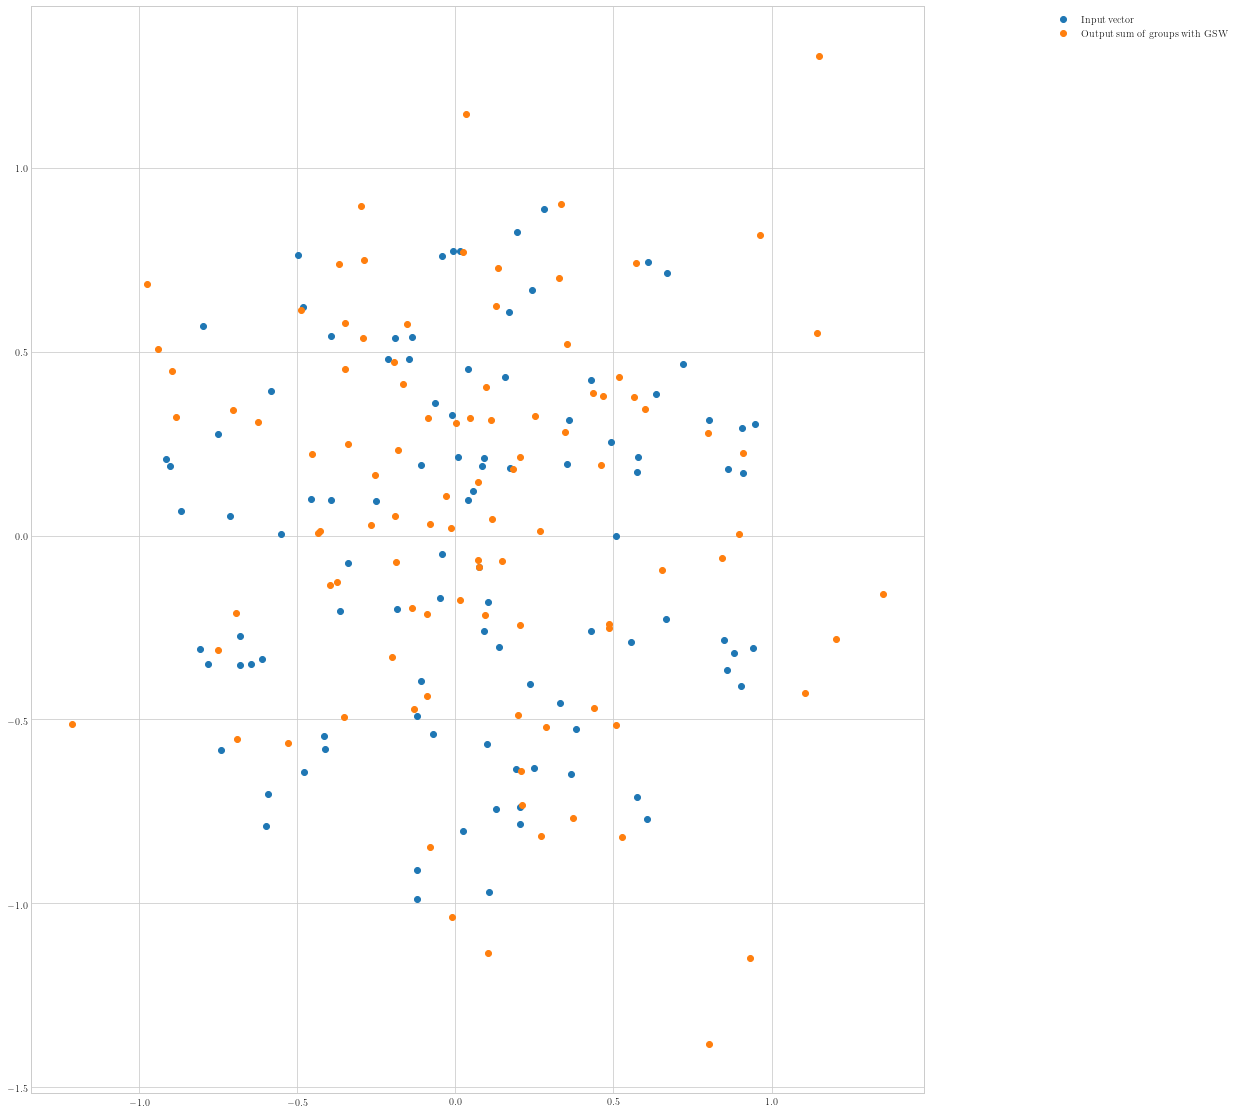

In [23]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    #print(i)
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


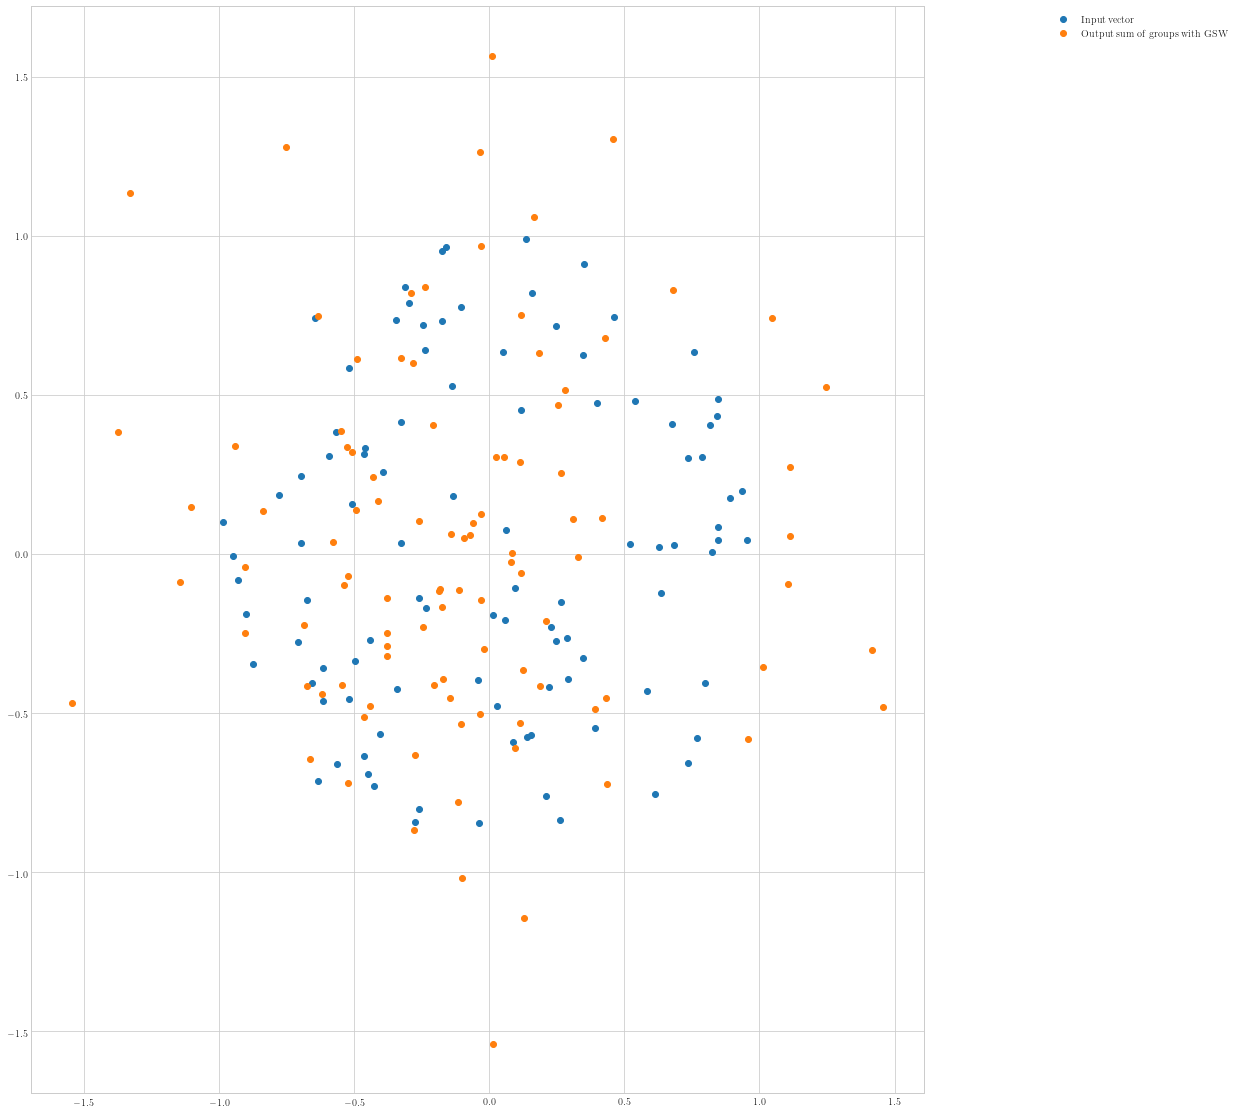

In [24]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,i_instead_of_d_inv=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


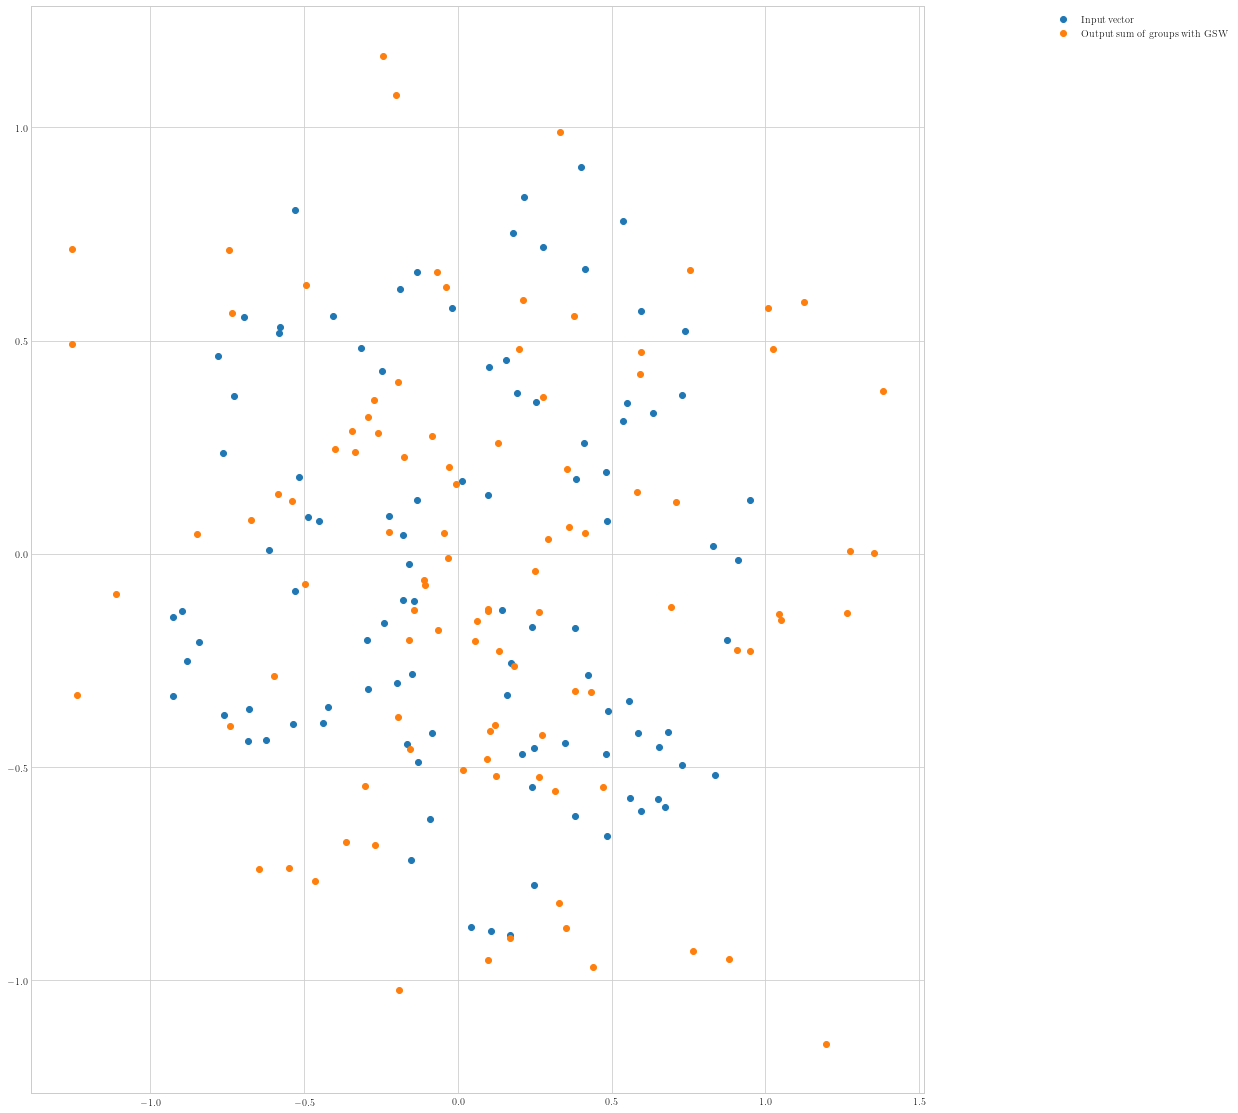

In [25]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,d_instead_of_d_inv=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


v_perp:[0. 0.]
v_perp-sum u_i*v_i:[ 7.66164021e-10 -1.82578930e-09]
v_perp:[0. 0.]
v_perp-sum u_i*v_i:[-3.41970008e-09  6.80302037e-10]
v_perp:[-3.55271368e-15 -1.42108547e-14]
v_perp-sum u_i*v_i:[ 2.17323404e-09 -2.99043279e-09]
v_perp:[2.84217094e-14 1.42108547e-14]
v_perp-sum u_i*v_i:[-5.75525405e-09 -2.66922484e-10]
v_perp:[  2.11871053 -64.59323   ]
v_perp-sum u_i*v_i:[-1.29581679e-09 -4.25046665e-11]
v_perp:[1.42108547e-14 0.00000000e+00]
v_perp-sum u_i*v_i:[2.27883135e-08 1.30530680e-08]
v_perp:[-124.43091916  -72.14009316]
v_perp-sum u_i*v_i:[ 8.14651457e-10 -1.40516931e-09]


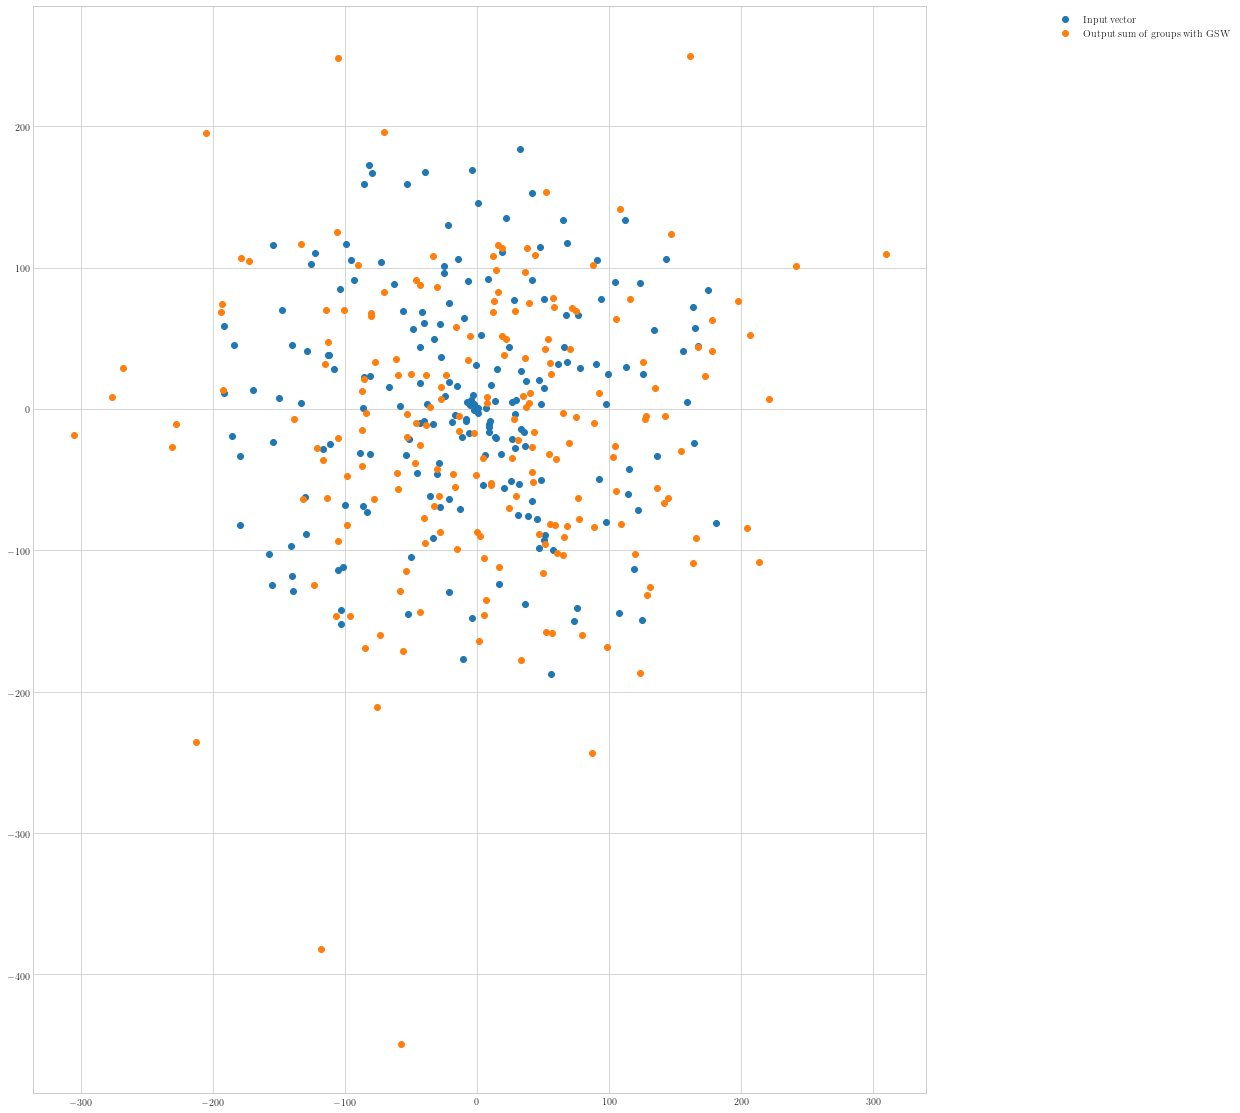

In [17]:
n=200
v=sample_from_ball(n,d=2)
for i in range(len(v)):
    v[i]=normalize(v[i])*(i+1)
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


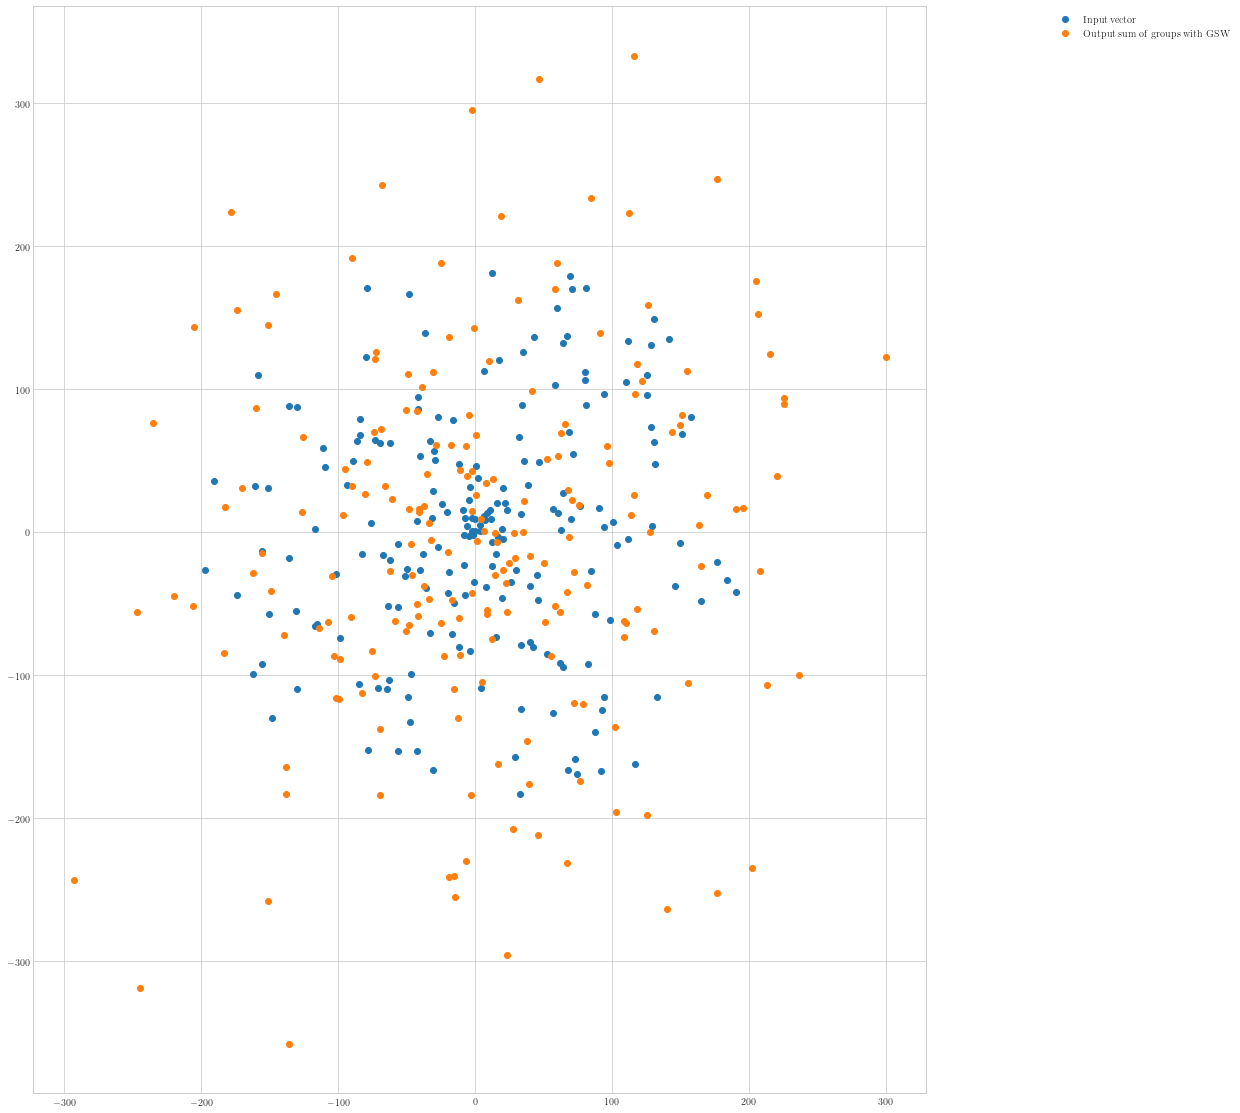

In [18]:
n=200
v=sample_from_ball(n,d=2)
for i in range(len(v)):
    v[i]=normalize(v[i])*(i+1)
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,i_instead_of_d_inv=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


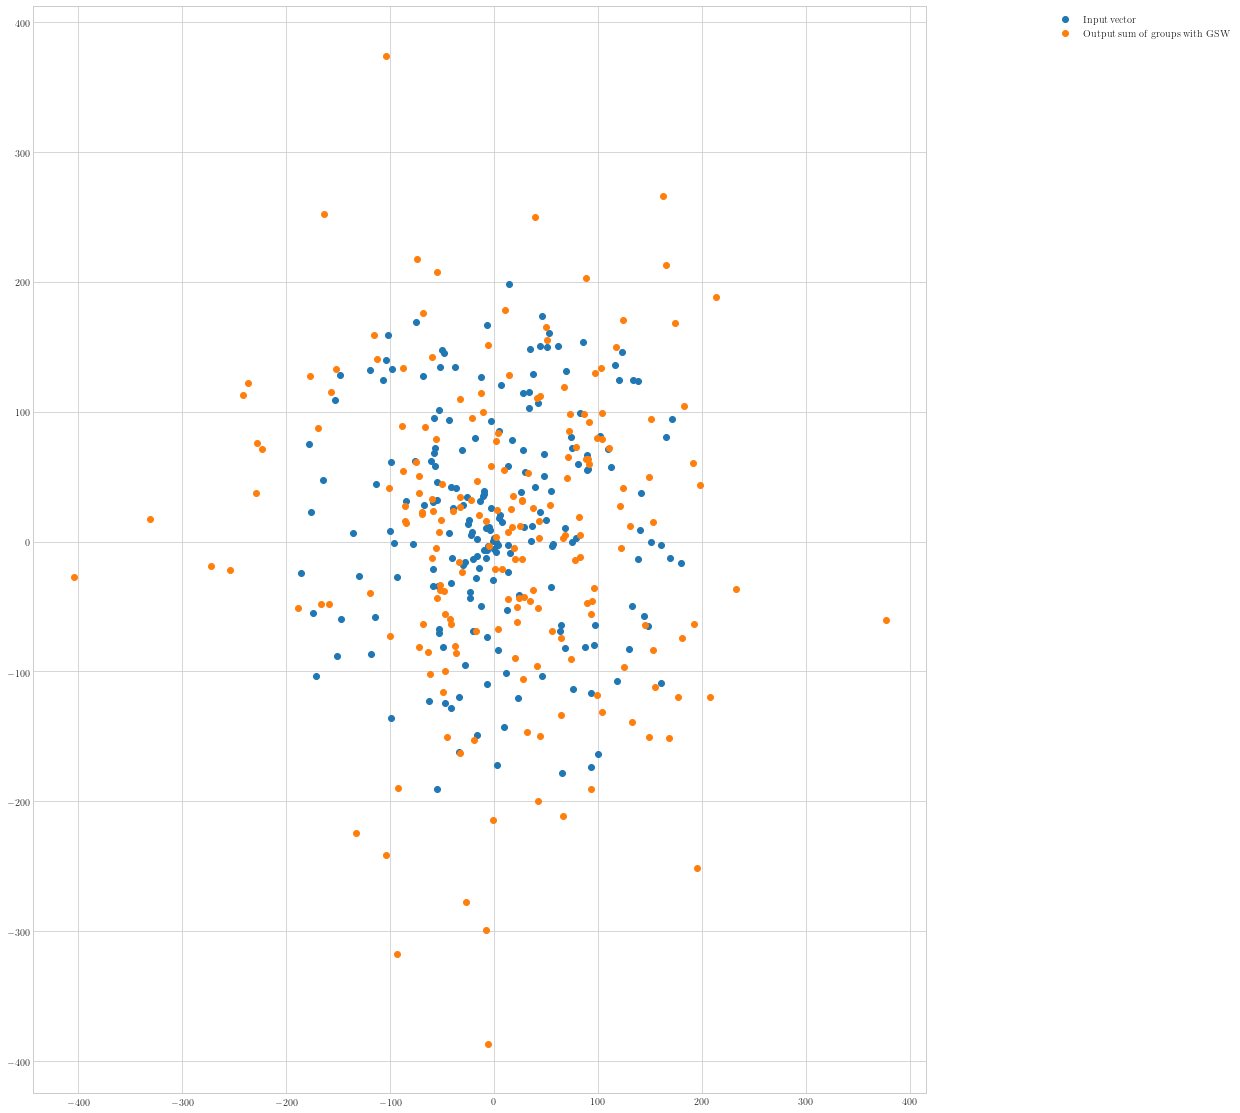

In [19]:
n=200
v=sample_from_ball(n,d=2)
for i in range(len(v)):
    v[i]=normalize(v[i])*(i+1)
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,d_instead_of_d_inv=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


v_perp:[0.00000000e+00 7.10542736e-15]
v_perp-sum u_i*v_i:[1.45623460e-08 1.02326077e-08]
v_perp:[0.00000000e+00 7.10542736e-15]
v_perp-sum u_i*v_i:[-5.03843012e-09  1.52363810e-09]
v_perp:[2.84217094e-14 0.00000000e+00]
v_perp-sum u_i*v_i:[-4.35903758e-10  3.05222159e-09]
v_perp:[0. 0.]
v_perp-sum u_i*v_i:[-2.98769010e-10 -1.92579819e-09]
v_perp:[0. 0.]
v_perp-sum u_i*v_i:[ 3.65682240e-09 -2.92160962e-09]
v_perp:[ 0.0000000e+00 -4.4408921e-16]
v_perp-sum u_i*v_i:[-8.88745853e-06  4.33996319e-07]
v_perp:[0. 0.]
v_perp-sum u_i*v_i:[7.35792582e-09 5.46842216e-09]
v_perp:[0.00000000e+00 2.84217094e-14]
v_perp-sum u_i*v_i:[-2.94994607e-09 -2.74209810e-09]
v_perp:[ 0.00000000e+00 -3.55271368e-15]
v_perp-sum u_i*v_i:[ 4.35875336e-10 -1.27045396e-09]
v_perp:[0. 0.]
v_perp-sum u_i*v_i:[1.40726115e-08 2.21411938e-08]
v_perp:[-2.84217094e-14 -2.84217094e-14]
v_perp-sum u_i*v_i:[ 4.22431867e-10 -4.04656930e-09]
v_perp:[-1.42108547e-14  0.00000000e+00]
v_perp-sum u_i*v_i:[1.95221617e-09 8.92441676

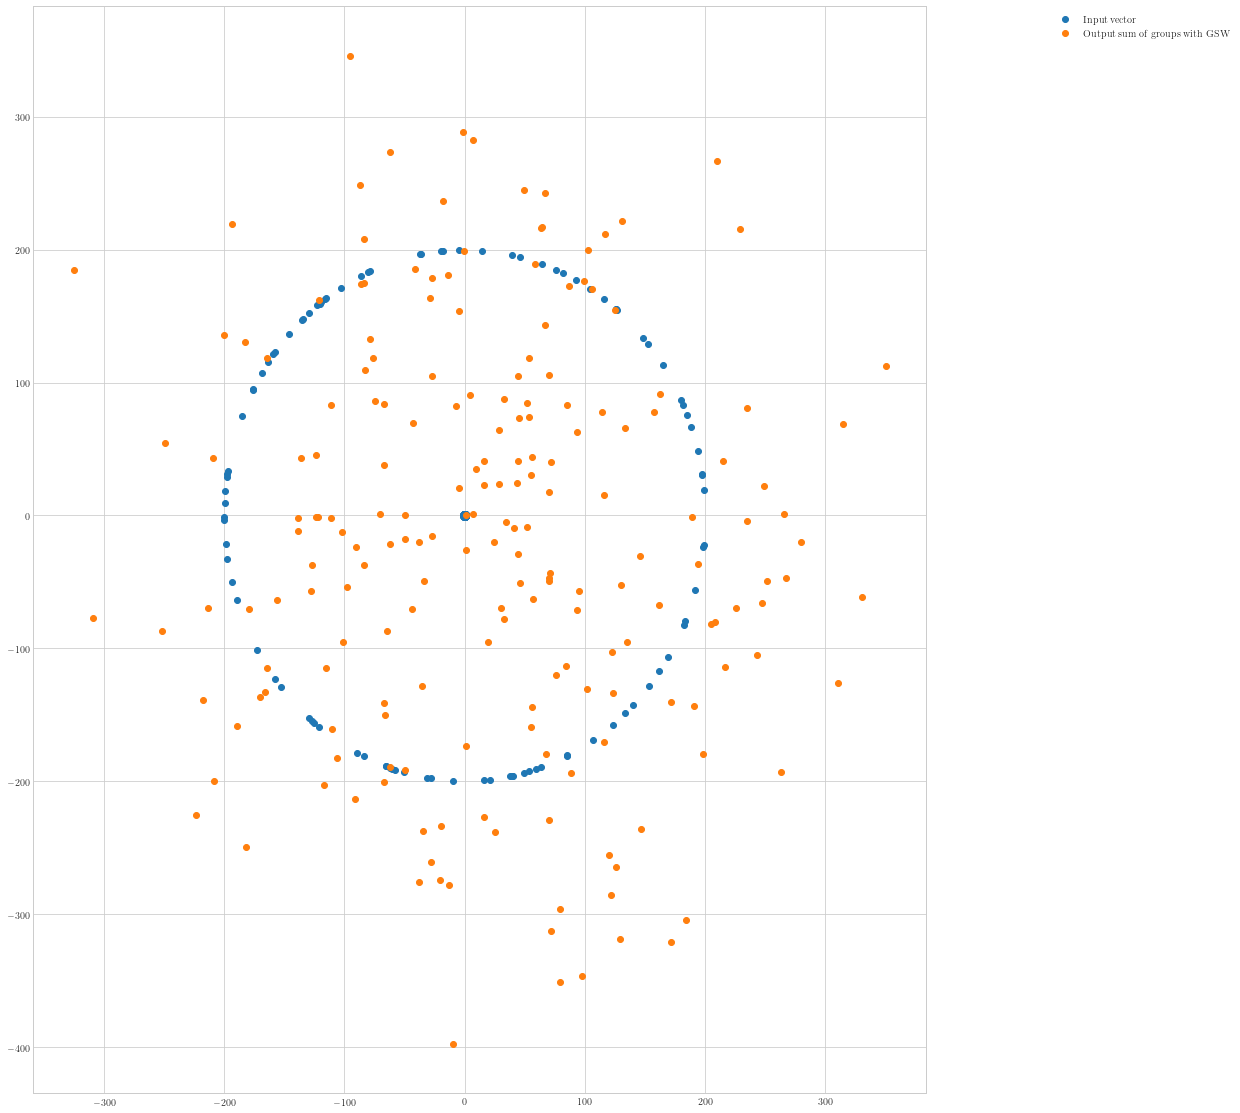

In [20]:
n=200
v=sample_from_ball(n,d=2)
for i in range(len(v)):
    v[i]=normalize(v[i])*(1 if i<n/2 else n)
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


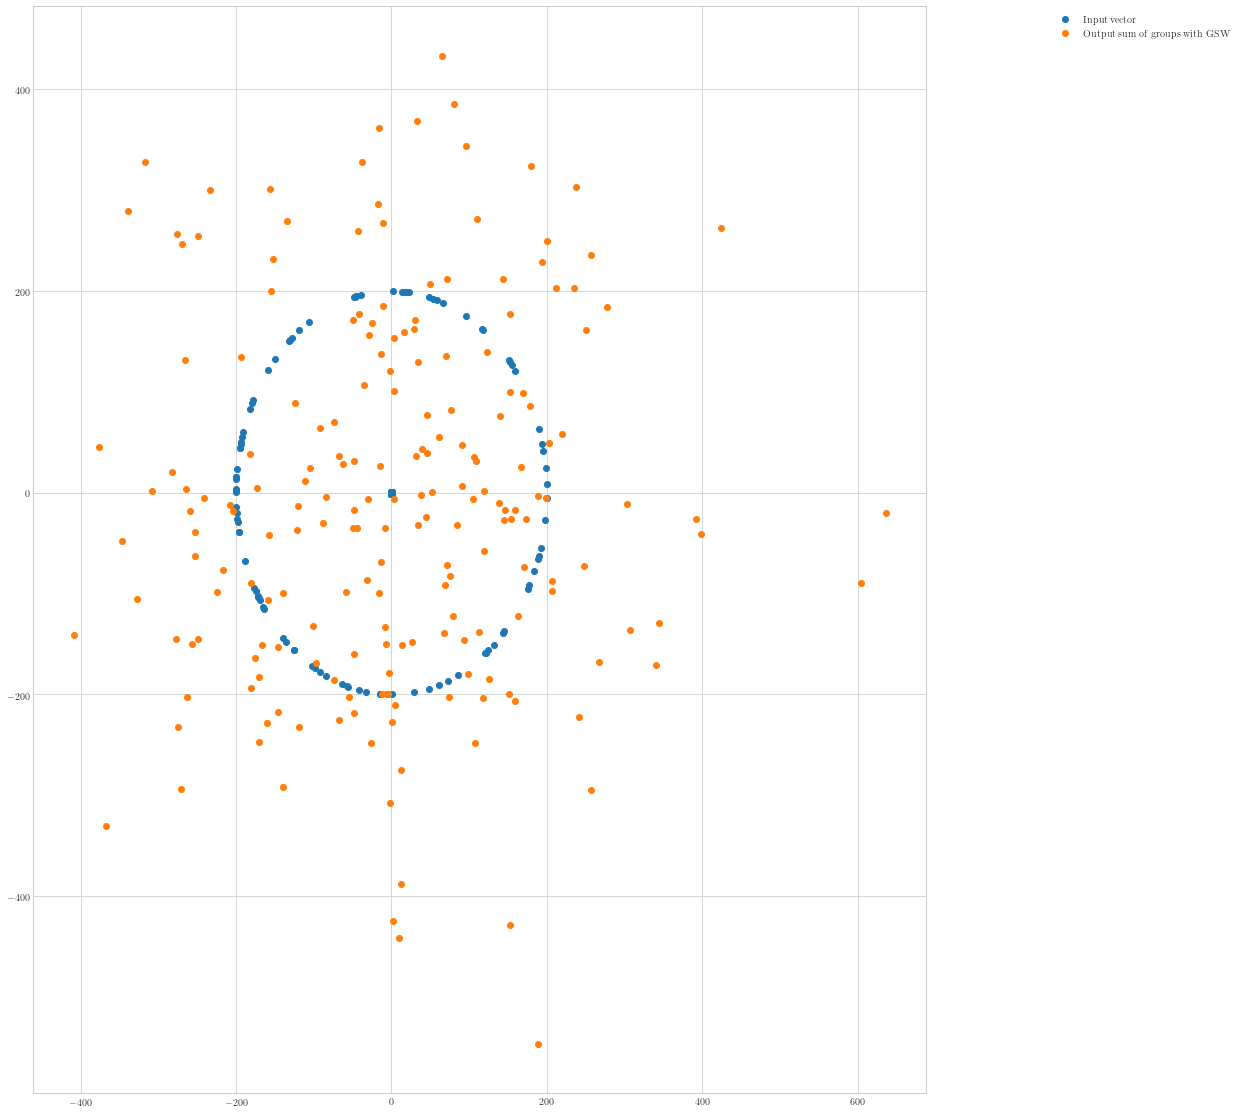

In [21]:
n=200
v=sample_from_ball(n,d=2)
for i in range(len(v)):
    v[i]=normalize(v[i])*(1 if i<n/2 else n)
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,i_instead_of_d_inv=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


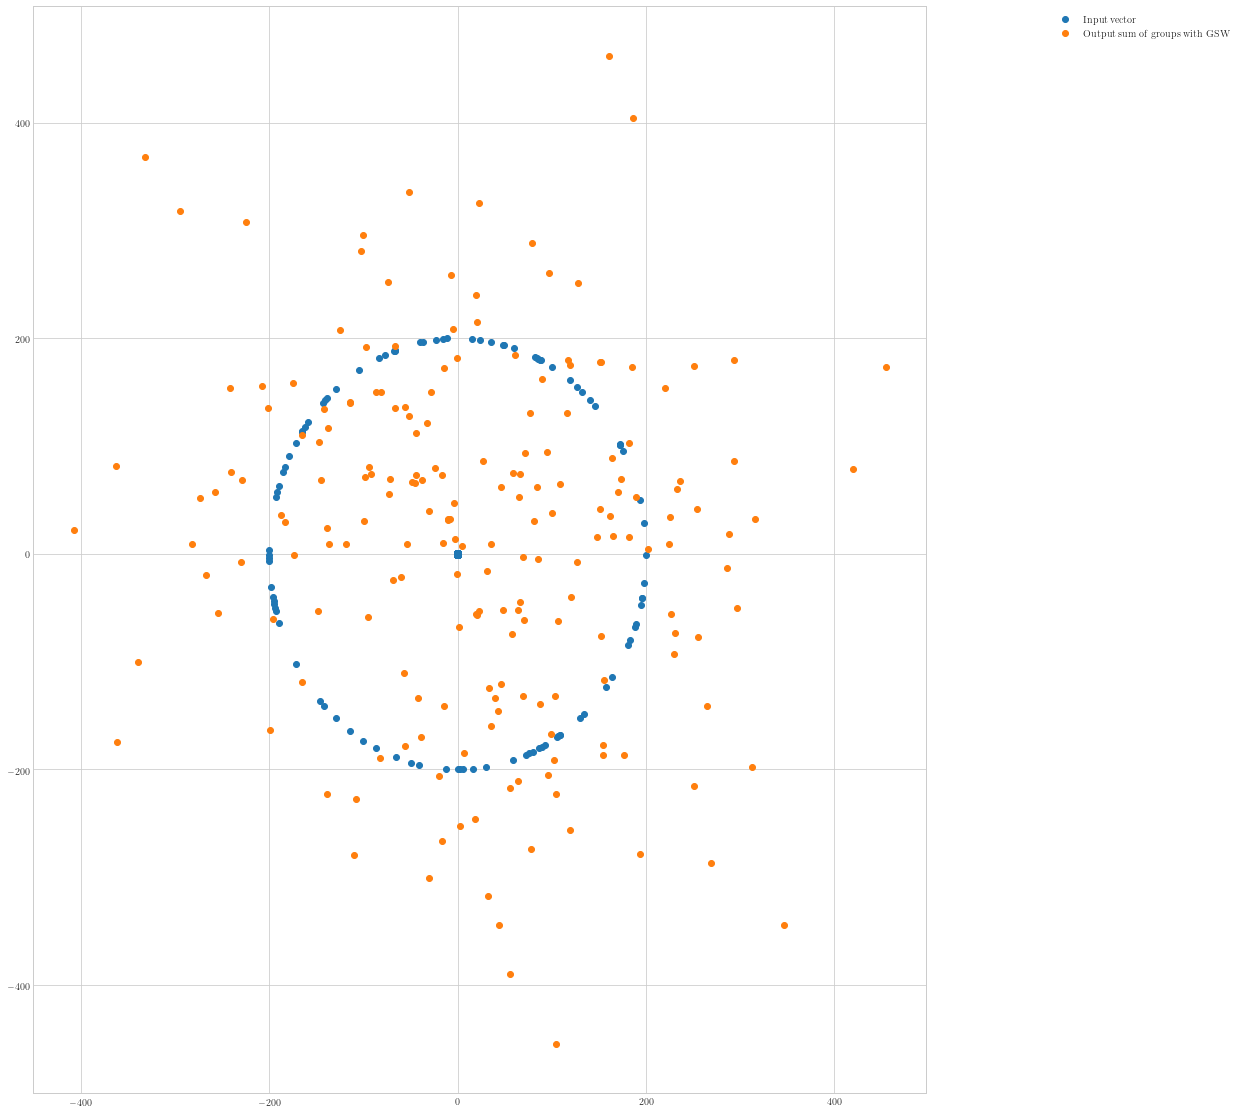

In [22]:
n=200
v=sample_from_ball(n,d=2)
for i in range(len(v)):
    v[i]=normalize(v[i])*(1 if i<n/2 else n)
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,d_instead_of_d_inv=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))

In [5]:
#Try with vectors of increasing length with non deterministic GSW 
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(i+1)
run_experiment(v,True,False)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):5970

 Try #1
sum(n-timestep)*norm(vector colored):6060

 Try #2
sum(n-timestep)*norm(vector colored):6306

 Try #3
sum(n-timestep)*norm(vector colored):6346

 Try #4
sum(n-timestep)*norm(vector colored):5402

 Try #5
sum(n-timestep)*norm(vector colored):6088

 Try #6
sum(n-timestep)*norm(vector colored):5590

 Try #7
sum(n-timestep)*norm(vector colored):6052

 Try #8
sum(n-timestep)*norm(vector colored):5456

 Try #9
sum(n-timestep)*norm(vector colored):5778

 Try #10
sum(n-timestep)*norm(vector colored):6084

 Try #11
sum(n-timestep)*norm(vector colored):6626

 Try #12
sum(n-timestep)*norm(vector colored):5786

 Try #13
sum(n-timestep)*norm(vector colored):6580

 Try #14
sum(n-timestep)*norm(vector colored):5988

 Try #15
sum(n-timestep)*norm(vector colored):6272

 Try #16
sum(n-timestep)*norm(vector colored):5704

 Try #17
sum(n-timestep)*norm(vector colored):7014

 Try #18
sum(n-timestep)*norm(vector colored):6270

 Try #19
sum(n-timestep)*norm(

In [6]:
#Try with vectors of increasing length with non deterministic GSW 
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(i+1)
run_experiment(v,False,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):13602

 Try #1
sum(n-timestep)*norm(vector colored):12952

 Try #2
sum(n-timestep)*norm(vector colored):13216

 Try #3
sum(n-timestep)*norm(vector colored):13806

 Try #4
sum(n-timestep)*norm(vector colored):13166

 Try #5
sum(n-timestep)*norm(vector colored):12462

 Try #6
sum(n-timestep)*norm(vector colored):13102

 Try #7
sum(n-timestep)*norm(vector colored):13004

 Try #8
sum(n-timestep)*norm(vector colored):12832

 Try #9
sum(n-timestep)*norm(vector colored):13370

 Try #10
sum(n-timestep)*norm(vector colored):12154

 Try #11
sum(n-timestep)*norm(vector colored):13702

 Try #12
sum(n-timestep)*norm(vector colored):13078

 Try #13
sum(n-timestep)*norm(vector colored):13872

 Try #14
sum(n-timestep)*norm(vector colored):13268

 Try #15
sum(n-timestep)*norm(vector colored):12394

 Try #16
sum(n-timestep)*norm(vector colored):13338

 Try #17
sum(n-timestep)*norm(vector colored):12970

 Try #18
sum(n-timestep)*norm(vector colored):12694

 Try #19
su

In [7]:
#Try with vectors of increasing length with deterministic GSW 
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(i+1)
run_experiment(v,True,False,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):6984

 Try #1
sum(n-timestep)*norm(vector colored):6906

 Try #2
sum(n-timestep)*norm(vector colored):6582

 Try #3
sum(n-timestep)*norm(vector colored):6140

 Try #4
sum(n-timestep)*norm(vector colored):6958

 Try #5
sum(n-timestep)*norm(vector colored):6624

 Try #6
sum(n-timestep)*norm(vector colored):6062

 Try #7
sum(n-timestep)*norm(vector colored):6836

 Try #8
sum(n-timestep)*norm(vector colored):7522

 Try #9
sum(n-timestep)*norm(vector colored):6852

 Try #10
sum(n-timestep)*norm(vector colored):6702

 Try #11
sum(n-timestep)*norm(vector colored):6646

 Try #12
sum(n-timestep)*norm(vector colored):7230

 Try #13
sum(n-timestep)*norm(vector colored):6956

 Try #14
sum(n-timestep)*norm(vector colored):6624

 Try #15
sum(n-timestep)*norm(vector colored):6554

 Try #16
sum(n-timestep)*norm(vector colored):6818

 Try #17
sum(n-timestep)*norm(vector colored):6394

 Try #18
sum(n-timestep)*norm(vector colored):7256

 Try #19
sum(n-timestep)*norm(

In [8]:
#Try with vectors of increasing length with deterministic GSW 
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(i+1)
run_experiment(v,False,True,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):12808

 Try #1
sum(n-timestep)*norm(vector colored):14034

 Try #2
sum(n-timestep)*norm(vector colored):12810

 Try #3
sum(n-timestep)*norm(vector colored):11836

 Try #4
sum(n-timestep)*norm(vector colored):12592

 Try #5
sum(n-timestep)*norm(vector colored):12144

 Try #6
sum(n-timestep)*norm(vector colored):12330

 Try #7
sum(n-timestep)*norm(vector colored):12348

 Try #8
sum(n-timestep)*norm(vector colored):13492

 Try #9
sum(n-timestep)*norm(vector colored):13614

 Try #10
sum(n-timestep)*norm(vector colored):13512

 Try #11
sum(n-timestep)*norm(vector colored):13058

 Try #12
sum(n-timestep)*norm(vector colored):13542

 Try #13
sum(n-timestep)*norm(vector colored):12114

 Try #14
sum(n-timestep)*norm(vector colored):12822

 Try #15
sum(n-timestep)*norm(vector colored):12202

 Try #16
sum(n-timestep)*norm(vector colored):12842

 Try #17
sum(n-timestep)*norm(vector colored):13874

 Try #18
sum(n-timestep)*norm(vector colored):13900

 Try #19
su

In [9]:
#Comparison with a group of vector with constant norm with non deterministic GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(n+1)/2
run_experiment(v,True,False)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):13790

 Try #1
sum(n-timestep)*norm(vector colored):13426

 Try #2
sum(n-timestep)*norm(vector colored):13126

 Try #3
sum(n-timestep)*norm(vector colored):13030

 Try #4
sum(n-timestep)*norm(vector colored):13936

 Try #5
sum(n-timestep)*norm(vector colored):13228

 Try #6
sum(n-timestep)*norm(vector colored):13598

 Try #7
sum(n-timestep)*norm(vector colored):12318

 Try #8
sum(n-timestep)*norm(vector colored):13634

 Try #9
sum(n-timestep)*norm(vector colored):13090

 Try #10
sum(n-timestep)*norm(vector colored):12410

 Try #11
sum(n-timestep)*norm(vector colored):13310

 Try #12
sum(n-timestep)*norm(vector colored):13932

 Try #13
sum(n-timestep)*norm(vector colored):13820

 Try #14
sum(n-timestep)*norm(vector colored):13790

 Try #15
sum(n-timestep)*norm(vector colored):13812

 Try #16
sum(n-timestep)*norm(vector colored):12728

 Try #17
sum(n-timestep)*norm(vector colored):12050

 Try #18
sum(n-timestep)*norm(vector colored):14044

 Try #19
su

In [10]:
#Comparison with a group of vector with constant norm with non deterministic GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(n+1)/2
run_experiment(v,False,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):13018

 Try #1
sum(n-timestep)*norm(vector colored):13750

 Try #2
sum(n-timestep)*norm(vector colored):13554

 Try #3
sum(n-timestep)*norm(vector colored):12950

 Try #4
sum(n-timestep)*norm(vector colored):12580

 Try #5
sum(n-timestep)*norm(vector colored):13590

 Try #6
sum(n-timestep)*norm(vector colored):13954

 Try #7
sum(n-timestep)*norm(vector colored):12970

 Try #8
sum(n-timestep)*norm(vector colored):12888

 Try #9
sum(n-timestep)*norm(vector colored):13568

 Try #10
sum(n-timestep)*norm(vector colored):14016

 Try #11
sum(n-timestep)*norm(vector colored):13588

 Try #12
sum(n-timestep)*norm(vector colored):12326

 Try #13
sum(n-timestep)*norm(vector colored):13298

 Try #14
sum(n-timestep)*norm(vector colored):12624

 Try #15
sum(n-timestep)*norm(vector colored):13140

 Try #16
sum(n-timestep)*norm(vector colored):13468

 Try #17
sum(n-timestep)*norm(vector colored):13004

 Try #18
sum(n-timestep)*norm(vector colored):13706

 Try #19
su

In [11]:
#Comparison with a group of vector with constant norm with deterministic GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(n+1)/2
run_experiment(v,True,False,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):12828

 Try #1
sum(n-timestep)*norm(vector colored):12368

 Try #2
sum(n-timestep)*norm(vector colored):12394

 Try #3
sum(n-timestep)*norm(vector colored):13402

 Try #4
sum(n-timestep)*norm(vector colored):12814

 Try #5
sum(n-timestep)*norm(vector colored):13994

 Try #6
sum(n-timestep)*norm(vector colored):14058

 Try #7
sum(n-timestep)*norm(vector colored):13562

 Try #8
sum(n-timestep)*norm(vector colored):13162

 Try #9
sum(n-timestep)*norm(vector colored):13206

 Try #10
sum(n-timestep)*norm(vector colored):13456

 Try #11
sum(n-timestep)*norm(vector colored):13350

 Try #12
sum(n-timestep)*norm(vector colored):12182

 Try #13
sum(n-timestep)*norm(vector colored):13926

 Try #14
sum(n-timestep)*norm(vector colored):13092

 Try #15
sum(n-timestep)*norm(vector colored):13022

 Try #16
sum(n-timestep)*norm(vector colored):13988

 Try #17
sum(n-timestep)*norm(vector colored):12868

 Try #18
sum(n-timestep)*norm(vector colored):12366

 Try #19
su

In [12]:
#Comparison with a group of vector with constant norm with deterministic GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(n+1)/2
run_experiment(v,False,True,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):13436

 Try #1
sum(n-timestep)*norm(vector colored):13016

 Try #2
sum(n-timestep)*norm(vector colored):14688

 Try #3
sum(n-timestep)*norm(vector colored):12520

 Try #4
sum(n-timestep)*norm(vector colored):14328

 Try #5
sum(n-timestep)*norm(vector colored):11814

 Try #6
sum(n-timestep)*norm(vector colored):13932

 Try #7
sum(n-timestep)*norm(vector colored):13430

 Try #8
sum(n-timestep)*norm(vector colored):13640

 Try #9
sum(n-timestep)*norm(vector colored):13728

 Try #10
sum(n-timestep)*norm(vector colored):14236

 Try #11
sum(n-timestep)*norm(vector colored):13394

 Try #12
sum(n-timestep)*norm(vector colored):13472

 Try #13
sum(n-timestep)*norm(vector colored):13742

 Try #14
sum(n-timestep)*norm(vector colored):13022

 Try #15
sum(n-timestep)*norm(vector colored):14032

 Try #16
sum(n-timestep)*norm(vector colored):12500

 Try #17
sum(n-timestep)*norm(vector colored):12842

 Try #18
sum(n-timestep)*norm(vector colored):13272

 Try #19
su

In [13]:
#Now with a group of big vectors and a group of small vectors and classical GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(1 if i<n/2 else n)
run_experiment(v,True,False)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):6432

 Try #1
sum(n-timestep)*norm(vector colored):6744

 Try #2
sum(n-timestep)*norm(vector colored):6836

 Try #3
sum(n-timestep)*norm(vector colored):6748

 Try #4
sum(n-timestep)*norm(vector colored):6410

 Try #5
sum(n-timestep)*norm(vector colored):6920

 Try #6
sum(n-timestep)*norm(vector colored):6578

 Try #7
sum(n-timestep)*norm(vector colored):6464

 Try #8
sum(n-timestep)*norm(vector colored):6942

 Try #9
sum(n-timestep)*norm(vector colored):7236

 Try #10
sum(n-timestep)*norm(vector colored):6840

 Try #11
sum(n-timestep)*norm(vector colored):6488

 Try #12
sum(n-timestep)*norm(vector colored):6152

 Try #13
sum(n-timestep)*norm(vector colored):6752

 Try #14
sum(n-timestep)*norm(vector colored):6860

 Try #15
sum(n-timestep)*norm(vector colored):6460

 Try #16
sum(n-timestep)*norm(vector colored):6640

 Try #17
sum(n-timestep)*norm(vector colored):6690

 Try #18
sum(n-timestep)*norm(vector colored):6972

 Try #19
sum(n-timestep)*norm(

In [14]:
#Now with a group of big vectors and a group of small vectors and classical GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(1 if i<n/2 else n)
run_experiment(v,False,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):13360

 Try #1
sum(n-timestep)*norm(vector colored):13730

 Try #2
sum(n-timestep)*norm(vector colored):13294

 Try #3
sum(n-timestep)*norm(vector colored):12430

 Try #4
sum(n-timestep)*norm(vector colored):13162

 Try #5
sum(n-timestep)*norm(vector colored):12176

 Try #6
sum(n-timestep)*norm(vector colored):12710

 Try #7
sum(n-timestep)*norm(vector colored):13208

 Try #8
sum(n-timestep)*norm(vector colored):13480

 Try #9
sum(n-timestep)*norm(vector colored):12516

 Try #10
sum(n-timestep)*norm(vector colored):12638

 Try #11
sum(n-timestep)*norm(vector colored):13158

 Try #12
sum(n-timestep)*norm(vector colored):12752

 Try #13
sum(n-timestep)*norm(vector colored):12418

 Try #14
sum(n-timestep)*norm(vector colored):13726

 Try #15
sum(n-timestep)*norm(vector colored):13384

 Try #16
sum(n-timestep)*norm(vector colored):13412

 Try #17
sum(n-timestep)*norm(vector colored):14774

 Try #18
sum(n-timestep)*norm(vector colored):12818

 Try #19
su

In [15]:
#Now with a group of big vectors and a group of small vectors and det GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(1 if i<n/2 else n)
run_experiment(v,True,False,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):7028

 Try #1
sum(n-timestep)*norm(vector colored):6930

 Try #2
sum(n-timestep)*norm(vector colored):6566

 Try #3
sum(n-timestep)*norm(vector colored):6718

 Try #4
sum(n-timestep)*norm(vector colored):6310

 Try #5
sum(n-timestep)*norm(vector colored):6788

 Try #6
sum(n-timestep)*norm(vector colored):6768

 Try #7
sum(n-timestep)*norm(vector colored):6636

 Try #8
sum(n-timestep)*norm(vector colored):7444

 Try #9
sum(n-timestep)*norm(vector colored):6282

 Try #10
sum(n-timestep)*norm(vector colored):7128

 Try #11
sum(n-timestep)*norm(vector colored):6524

 Try #12
sum(n-timestep)*norm(vector colored):6686

 Try #13
sum(n-timestep)*norm(vector colored):6886

 Try #14
sum(n-timestep)*norm(vector colored):6674

 Try #15
sum(n-timestep)*norm(vector colored):6832

 Try #16
sum(n-timestep)*norm(vector colored):6510

 Try #17
sum(n-timestep)*norm(vector colored):6392

 Try #18
sum(n-timestep)*norm(vector colored):6880

 Try #19
sum(n-timestep)*norm(

In [16]:
#Now with a group of big vectors and a group of small vectors and det GSW
n=200
v=sample_from_ball(n,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])*(1 if i<n/2 else n)
run_experiment(v,False,True,True)


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:291: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


sum(n-timestep)*norm(vector colored):13772

 Try #1
sum(n-timestep)*norm(vector colored):13134

 Try #2
sum(n-timestep)*norm(vector colored):14296

 Try #3
sum(n-timestep)*norm(vector colored):13246

 Try #4
sum(n-timestep)*norm(vector colored):14096

 Try #5
sum(n-timestep)*norm(vector colored):13556

 Try #6
sum(n-timestep)*norm(vector colored):14446

 Try #7
sum(n-timestep)*norm(vector colored):13488

 Try #8
sum(n-timestep)*norm(vector colored):14202

 Try #9
sum(n-timestep)*norm(vector colored):13516

 Try #10
sum(n-timestep)*norm(vector colored):12578

 Try #11
sum(n-timestep)*norm(vector colored):11964

 Try #12
sum(n-timestep)*norm(vector colored):15182

 Try #13
sum(n-timestep)*norm(vector colored):13824

 Try #14
sum(n-timestep)*norm(vector colored):13552

 Try #15
sum(n-timestep)*norm(vector colored):13550

 Try #16
sum(n-timestep)*norm(vector colored):13926

 Try #17
sum(n-timestep)*norm(vector colored):13638

 Try #18
sum(n-timestep)*norm(vector colored):13968

 Try #19
su